# Evaluation NER - Sorties HTR brutes

## Cas d'usage - indexation automatique des noms de personne et d'organisation des enregistrements des pages des répertoires de notaires

Pour se rendre compte de l'efficacité et la régularité du NER, on peut observer chaque première entité de chaque enregistrement. Dans le cas de LECTAUREP, celles-ci doivent nécessairement être une `PER` (personne) ou une `ORG` (organisation). Si l'extraction est régulière, on peut envisager le cas d'une indexation automatique des noms de personnes et d'organisations présents dans les répertoires de notaires.

Dans cette expérience, on mesurera donc cette régularité en fonction du score de CER, sur une seule et même page.

Le CER a été obtenu en appliquant plusieurs modèles d'HTR et grâce à la librairie [KaMI](https://gitlab.inria.fr/dh-projects/kami/kami-lib).

## Imports et modèle de langue

In [1]:
from pathlib import Path
import re

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import spacy

 On charge le [modèle de langue française](https://spacy.io/models/fr#fr_core_news_lg) de spaCy.

In [2]:
nlp_pipeline_fr = spacy.load("fr_core_news_lg")

## Fonctions utilisées pour les tests

Pour le pré-traitement, on utilise la segmentation des régions et l'annotation sémantique des baselines d'eScriptorium.

On récupère la colonne 5, et on crée une liste qui contiendra un enregistrement par index.

`[enregistrement 1, enregistrement 2, enregistrement 3]`

Chaque index passera dans la pipeline NLP.

On essaye également de corriger l'HTR en séparant les mots aglutinés à l'aide des majuscules, et en utilisant des regex.

In [3]:
def open_and_parse(source):
    '''open a file and parsed its content with BeautifulSoup'''
    with open(source, 'r', encoding='utf8') as fh:
        file_content = fh.read()
    parsed_source = BeautifulSoup(file_content, 'xml')
    return parsed_source


def split_word_on_caps(entry):
    '''
    Spots words stuck together and split them using regex
    
    e.g. thisIsAnExample --> this Is An Example
    '''
    
    # word segmentation using regex
    # regex are based on study of LECTAUREP's textual data and its recurrent errors
    letter_before_caps_splitted = re.sub(r"(\w)([A-Z])", r"\1 \2", entry)
    # undo previous correction of an abbreviation used in the répertoires de notaires
    correction_abbreviated_sson = re.sub("S Son", "SSon", letter_before_caps_splitted)
    blank_space_address_number = re.sub(r'(\d{2})([A-z])', r'\1 \2', correction_abbreviated_sson)
    special_character_before_caps_splitted = re.sub(r"(\))([A-Z])", r"\1 \2", blank_space_address_number)
    blank_space_address = re.sub("del'", "de l'", special_character_before_caps_splitted)
    blank_space_ruede = re.sub("ruede", "rue de", blank_space_address)
    blank_space_ruedu = re.sub("ruedu", "rue du", blank_space_ruede)
    blank_space_ruedela = re.sub("ruedela", "rue de la", blank_space_ruedu)
    blank_space_sondomicile = re.sub("sondomicile", "son domicile", blank_space_ruedela)
    blank_space_beginning_date = re.sub("([A-z])([1-9])", r"\1 \2", blank_space_sondomicile)
    blank_space_month_year = re.sub(r"([A-z])(\d{3,4})", r"\1 \2", blank_space_beginning_date)
    blank_space_before_parenthesis = re.sub(r"([A-z])(\()", r"\1 \2", blank_space_month_year)
    # First encoding for à : \xc3\xa0
    blank_space_before_à = re.sub(r"([^l\s])(à)", r"\1 \2", blank_space_before_parenthesis)
    blank_space_after_à = re.sub(r"(à)([A-z])", r"\1 \2", blank_space_before_à)
    # Second encoding for à : a\xcc\x80
    blank_space_before_à_2 = re.sub(r"([^l\s])(à)", r"\1 \2", blank_space_after_à)
    blank_space_after_à_2 = re.sub(r"(à)([A-z])", r"\1 \2", blank_space_before_à_2)

    return blank_space_after_à_2


def get_transcription_list(xml_tree):
    '''find text nodes in PAGE XML and get them ready for NER processing'''
    transcriptions = []
    col_5 = xml_tree.find_all('TextRegion', custom="structure {type:col_5;}")
    
    for col in col_5:
        baselines = col.find_all('TextLine')
        for baseline in baselines:
            if baseline.has_attr('custom'):
                if baseline['custom'] == 'structure {type:first_line;}':
                    transcriptions.append([baseline.text.strip('\n')])
            else:
                transcriptions[-1].append(baseline.text.strip('\n'))
                
    transcriptions = [[' '.join(transcription)] for transcription in transcriptions]
    transcriptions_flat_list = [entry for sublist in transcriptions for entry in sublist]
                    
    return transcriptions_flat_list

## Fonctions de visualisation

In [4]:
def show_entities(nlp_processed_text):
    '''for each entry in a page, show the entry and its named entities'''
    for enregistrement in nlp_processed_text:
        print(enregistrement)
        print('\n')
        for ent in enregistrement.ents:
            print(ent.text, ent.label_)
        print('_________ \n')
        
        
def show_ner_prediction_nb(nlp_processed_text):
    '''based on NER prediction, show how many named entities were recognized in a page'''
    ent_count = 0
    for enregistrement in nlp_processed_text:
        ent_count += len(enregistrement.ents)
    print(f'Prédiction NER : {ent_count} entités nommées')
    
    return ent_count

### Métriques

Pour une page avec 18 entrées, on devrait pouvoir retrouver 18 entités `ORG` ou `PER` en première place. 

Avec ces données, on peut ainsi calculer l'accuracy de la façon de suivante :

$$
\frac{y}{x} \times 100 = P
$$

Où $y$ correspond au nombre d'entités correctement labellisées en tant que PER ou ORG, et $x$ au nombre d'enregistrements.

L'accuracy nous indique le pourcentage de bonnes prédictions.

In [5]:
def how_many_entries(transcription):
    '''count how many entries are there in a list'''
    return len(transcription)

def count_per_org(processed_transcriptions):
    '''return how many first tokens for each entry are PER or ORG'''
    count_per_org = 0
    for enregistrement in processed_transcriptions:
        ent_list = []
        if enregistrement.ents:
            for ent in enregistrement.ents:
                ent_list.append(ent.label_)
            if ent_list[0] == 'PER' or ent_list[0] == 'ORG':
                count_per_org += 1
            
    return count_per_org

def compute_accuracy(correct_entities, nb_entries):
    '''compute accuracy'''
    return correct_entities / nb_entries * 100

## CER 0%

On traite le fichier source en le parsant, en récupérant les enregistrements, et en séparant les mots agglutinés.

In [6]:
source_cer_0 = "../../corpus_test/lectaurep/ner_test_first_token/img_1/pagexml/cer_0/DAFANCH96_023MIC07640_L-1.xml"
content_cer_0 = open_and_parse(source_cer_0)
sample_cer_0 = get_transcription_list(content_cer_0)
sample_splitted_cer_0 = [split_word_on_caps(entry) for entry in sample_cer_0]

In [7]:
sample_splitted_cer_0

["Beaurepaire (par henri Frédéric) et Marie Celine X XX safemme, demeurant à Paris, passage Tivoli 18, à Etienne Arthur Decan et Louise Félicienne Grante, sa femme, demeurant à Paris, passage Lathuile 21, d'unfonds deboucherie à Paris passage Tivoli 18, moyennant 24000+",
 "Institut agricole de Giel (pour laformation d'un institut agricole sous le nom de) dont le siège social est établi à Giel (Eure), pour développer l'étude de l'agriculture dans les classes pauvres.",
 'Lavignolle (rectificative par herman) etréquisition de certificat depropriété.',
 'Imbeaux (depièces constatantles publications de contratdemariage de M Imbeaux avec Melle Livet.',
 "Reynoso (par Alvaro Francisco Carlos) demeurant à Paris rue de Chateaudun 40 à (en blanc) à l'effetdeprendre un brevet d'invention dansla République Argentine pourla conservation desviandes.",
 'Cayre (par Marie Françoise honorine X XX, épouse de Pierre Louis) demeurant à Paris, rue du Havre, n°11 à Valentin Martin, demeurant à Paris avenu

Chaque enregistrement passe par la chaîne de traitement de TAL spaCy.

In [8]:
sample_processed_cer_0 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_0]

In [9]:
show_entities(sample_processed_cer_0)

Beaurepaire (par henri Frédéric) et Marie Celine X XX safemme, demeurant à Paris, passage Tivoli 18, à Etienne Arthur Decan et Louise Félicienne Grante, sa femme, demeurant à Paris, passage Lathuile 21, d'unfonds deboucherie à Paris passage Tivoli 18, moyennant 24000+


Beaurepaire PER
Frédéric PER
Marie Celine X XX safemme PER
Paris LOC
Tivoli 18 LOC
Etienne Arthur Decan PER
Louise Félicienne Grante PER
Paris LOC
Lathuile 21 LOC
Paris LOC
Tivoli 18 LOC
_________ 

Institut agricole de Giel (pour laformation d'un institut agricole sous le nom de) dont le siège social est établi à Giel (Eure), pour développer l'étude de l'agriculture dans les classes pauvres.


Institut agricole de Giel ORG
Giel LOC
Eure LOC
_________ 

Lavignolle (rectificative par herman) etréquisition de certificat depropriété.


Lavignolle LOC
_________ 

Imbeaux (depièces constatantles publications de contratdemariage de M Imbeaux avec Melle Livet.


Imbeaux PER
M Imbeaux PER
Melle Livet PER
_________ 

Reynoso (pa

On stocke le nombre d'entités extraites.

In [10]:
entity_count_cer_0 = show_ner_prediction_nb(sample_processed_cer_0)

Prédiction NER : 96 entités nommées


On stocke les mesures relatives à notre expérience : 

* le nombre d'enregistrements présents sur la page
* le nombre de premières entités étant PER ou ORG
* l'accuracy

In [11]:
nb_entries_cer_0 = how_many_entries(sample_cer_0)
nb_per_org_cer_0 = count_per_org(sample_processed_cer_0)
accuracy_cer_0 = compute_accuracy(nb_per_org_cer_0, nb_entries_cer_0)

In [12]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_0} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_0}')

print(f'Accuracy : {accuracy_cer_0}')

Nombre d'enregistrements présents sur la page : 20 	 Nombre de premières entités étant PER ou ORG : 8
Accuracy : 40.0


## CER 8%

In [13]:
source_cer_8 = "../../corpus_test/lectaurep/ner_test_first_token/img_1/pagexml/cer_8/DAFANCH96_023MIC07640_L-1.xml"
content_cer_8 = open_and_parse(source_cer_8)
sample_cer_8 = get_transcription_list(content_cer_8)
sample_splitted_cer_8 = [split_word_on_caps(entry) for entry in sample_cer_8]

In [14]:
sample_splitted_cer_8

["Beaurepaire (parhenri Frédéric) et Marie Celina Hutin safemme, demeurantà Paris, passage Tivoli 18, à Etienne Arthur Decan et Louise Félicienne Grante, safemme, demeurant à Paris, passage Lathuile 21, d'unfonds deboucherie à Paris passage Teivoli 18, moyennant 24000+",
 "Institut agricole de Giel (pour laformation d'un institut agricole sous le nom de) dont le siège social est établi à Giee (Eure), pour développer l'étude de l'agrieulture dans les classes pauvres.",
 'Lavignolle (rectificative parherman) etrequistion derertificat depropriété',
 'Imibeaux (depièces constatantles publications de contrat demariage de M Imbeaux avecc Melle Livet',
 "Reynoso (par Alvaro Francisco Carlos) demeurant à Paris rue de Chateaudun 40 à (en blanc) à l'effetdeprendreun brevet d'inenion dansla République Argentine pourla conservation des Viandes.",
 'Cayre (par Marie Françoise honone Teninse, épouse de Pierre Louis) demeurant à Paris, rue du Havre, n°11 à Valantin Martin, deme

In [15]:
sample_processed_cer_8 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_8]

In [16]:
show_entities(sample_processed_cer_8)

Beaurepaire (parhenri Frédéric) et Marie Celina Hutin safemme, demeurantà Paris, passage Tivoli 18, à Etienne Arthur Decan et Louise Félicienne Grante, safemme, demeurant à Paris, passage Lathuile 21, d'unfonds deboucherie à Paris passage Teivoli 18, moyennant 24000+


Beaurepaire PER
parhenri Frédéric MISC
Marie Celina Hutin PER
Paris LOC
Tivoli 18 LOC
Etienne Arthur Decan PER
Louise Félicienne Grante PER
Paris LOC
Lathuile 21 LOC
Paris LOC
_________ 

Institut agricole de Giel (pour laformation d'un institut agricole sous le nom de) dont le siège social est établi à Giee (Eure), pour développer l'étude de l'agrieulture dans les classes pauvres.


Institut agricole de Giel ORG
Giee LOC
Eure LOC
_________ 

Lavignolle (rectificative parherman) etrequistion derertificat depropriété


Lavignolle LOC
_________ 

Imibeaux (depièces constatantles publications de contrat demariage de M Imbeaux avecc Melle Livet


Imibeaux LOC
M Imbeaux PER
Melle Livet PER
_________ 

Reynos

In [17]:
entity_count_cer_8 = show_ner_prediction_nb(sample_processed_cer_8)

Prédiction NER : 97 entités nommées


In [18]:
nb_entries_cer_8 = how_many_entries(sample_cer_8)
nb_per_org_cer_8 = count_per_org(sample_processed_cer_8)
accuracy_cer_8 = compute_accuracy(nb_per_org_cer_8, nb_entries_cer_8)

In [19]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_8} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_8}')

print(f'Accuracy : {accuracy_cer_8}')

Nombre d'enregistrements présents sur la page : 20 	 Nombre de premières entités étant PER ou ORG : 7
Accuracy : 35.0


## CER 18%

In [20]:
source_cer_18 = "../../corpus_test/lectaurep/ner_test_first_token/img_1/pagexml/cer_18/DAFANCH96_023MIC07640_L-1.xml"
content_cer_18 = open_and_parse(source_cer_18)
sample_cer_18 = get_transcription_list(content_cer_18)
sample_splitted_cer_18 = [split_word_on_caps(entry) for entry in sample_cer_18]

In [21]:
sample_splitted_cer_18

["Beaurepaire (par henre Frédéric) et Marie Celnatictn sa femme, demeurant à Paris, passage Tivoli 18, à Etienne Acthur Diean et Louise Félicienne Grante, sa femme, demeurant à Paris, passage Lathuile 21, d'in fonds de boucherie à Paris prassage Teivoli 18, moyennant Eyovot",
 "Insttut agricole de Giel (pour laformation d'un institut agucole sons le rom de) dont l siège social ett établi à Giee (Eure), pour développer l'étuide de l'agrieulture dans les classes pauvres.",
 'Lavignolle (rectificauve par herman) etrequintion derertificat de propriété',
 'Imbeaux (deprèces constatant les publications de contrat de manage de M Imbeaux aveec M^ve Livet',
 "Leynoso (par Alvrs Francisc Carlos) demeurant à Paris rue de Chateaudun 40 à (en blanc) à l'effet deprendre en brevet d'invenicon dans les Repulle que Argentine pour le conernation der Viandes.",
 'Cayre (par Marie Françoise hononne Temine, épouse de Pierre Louis) demeurant à Paris, rue de Havre, n° 11 a Velarti Martin

In [22]:
sample_processed_cer_18 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_18]

In [23]:
show_entities(sample_processed_cer_18)

Beaurepaire (par henre Frédéric) et Marie Celnatictn sa femme, demeurant à Paris, passage Tivoli 18, à Etienne Acthur Diean et Louise Félicienne Grante, sa femme, demeurant à Paris, passage Lathuile 21, d'in fonds de boucherie à Paris prassage Teivoli 18, moyennant Eyovot


Beaurepaire PER
Frédéric LOC
Marie Celnatictn PER
Paris LOC
Tivoli 18 LOC
Etienne Acthur Diean PER
Louise Félicienne Grante PER
Paris LOC
Lathuile 21 LOC
Paris LOC
Teivoli 18 MISC
Eyovot ORG
_________ 

Insttut agricole de Giel (pour laformation d'un institut agucole sons le rom de) dont l siège social ett établi à Giee (Eure), pour développer l'étuide de l'agrieulture dans les classes pauvres.


Insttut MISC
Giel LOC
Giee LOC
Eure LOC
_________ 

Lavignolle (rectificauve par herman) etrequintion derertificat de propriété


Lavignolle LOC
_________ 

Imbeaux (deprèces constatant les publications de contrat de manage de M Imbeaux aveec M^ve Livet


Imbeaux PER
M Imbeaux PER
M^ve Livet PER
_________ 

In [24]:
entity_count_cer_18 = show_ner_prediction_nb(sample_processed_cer_18)

Prédiction NER : 97 entités nommées


In [25]:
nb_entries_cer_18 = how_many_entries(sample_cer_18)
nb_per_org_cer_18 = count_per_org(sample_processed_cer_18)
accuracy_cer_18 = compute_accuracy(nb_per_org_cer_18, nb_entries_cer_18)

In [26]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_18} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_18}')

print(f'Accuracy : {accuracy_cer_18}')

Nombre d'enregistrements présents sur la page : 20 	 Nombre de premières entités étant PER ou ORG : 6
Accuracy : 30.0


## CER 25%

In [27]:
source_cer_25 = "../../corpus_test/lectaurep/ner_test_first_token/img_1/pagexml/cer_25/DAFANCH96_023MIC07640_L-1.xml"
content_cer_25 = open_and_parse(source_cer_25)
sample_cer_25 = get_transcription_list(content_cer_25)
sample_splitted_cer_25 = [split_word_on_caps(entry) for entry in sample_cer_25]

In [28]:
sample_splitted_cer_25

['Beaurepaire par henri Frederic et Marie Celna hictin du femme, demeurant à Paris Massage Tivoli 18, à Tlienne Alithur Dican et Louise Pelicienne Grante, sa femme, demeurant à Paris, passage Lathuile 21, dbn fonds Le boucherie à Paris passage Teivoli 18, moyennat Ayovot.',
 "Inbtitut agricole de Giel pour la formation d'un. mnstitut annicole Vons le nom de dont le Siège socue. est etabli à Giel l'Eure, pour Lévelopper l'elude de l'agroenlture Laus les Classes hanvres.",
 'Luvignolle Crectifucative par herman etrequisition. de rertifieut de proeprieté.',
 'Imibeaux de prieces constatant les publications de contrat Le mariage de M Imbeaux ave ^le Rivec.',
 "Reynosi par Alvro Fremcisce Carlos, demeurant à Paris ruc de Chateau dun 40 à Cen blanc à l'effet de presdre un brevet d'unvenicon Lunr le Repube que Argestne pires le coneration des Viomdes.",
 'Tayre par Marie Freneoire hononme Tenrisse, épouse de Pierre Lons dememant à Paris, rue du Wavre, ne 11 à Valastne Mantric, d

In [29]:
sample_processed_cer_25 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_25]

In [30]:
show_entities(sample_processed_cer_25)

Beaurepaire par henri Frederic et Marie Celna hictin du femme, demeurant à Paris Massage Tivoli 18, à Tlienne Alithur Dican et Louise Pelicienne Grante, sa femme, demeurant à Paris, passage Lathuile 21, dbn fonds Le boucherie à Paris passage Teivoli 18, moyennat Ayovot.


Beaurepaire PER
Frederic PER
Marie Celna PER
Paris LOC
Tlienne Alithur Dican PER
Louise Pelicienne PER
Paris LOC
Lathuile LOC
Paris LOC
Ayovot PER
_________ 

Inbtitut agricole de Giel pour la formation d'un. mnstitut annicole Vons le nom de dont le Siège socue. est etabli à Giel l'Eure, pour Lévelopper l'elude de l'agroenlture Laus les Classes hanvres.


Inbtitut LOC
Giel LOC
mnstitut annicole MISC
Siège MISC
Giel LOC
Eure LOC
Lévelopper LOC
Laus LOC
Classes hanvres MISC
_________ 

Luvignolle Crectifucative par herman etrequisition. de rertifieut de proeprieté.


Luvignolle Crectifucative PER
_________ 

Imibeaux de prieces constatant les publications de contrat Le mariage de M Imbeaux ave ^le Rivec.


Imi

In [31]:
entity_count_cer_25 = show_ner_prediction_nb(sample_processed_cer_25)

Prédiction NER : 107 entités nommées


In [32]:
nb_entries_cer_25 = how_many_entries(sample_cer_25)
nb_per_org_cer_25 = count_per_org(sample_processed_cer_25)
accuracy_cer_25 = compute_accuracy(nb_per_org_cer_25, nb_entries_cer_25)

In [33]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_25} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_25}')

print(f'Accuracy : {accuracy_cer_25}')

Nombre d'enregistrements présents sur la page : 20 	 Nombre de premières entités étant PER ou ORG : 7
Accuracy : 35.0


## CER 31%

In [34]:
source_cer_31 = "../../corpus_test/lectaurep/ner_test_first_token/img_1/pagexml/cer_31/DAFANCH96_023MIC07640_L-1.xml"
content_cer_31 = open_and_parse(source_cer_31)
sample_cer_31 = get_transcription_list(content_cer_31)
sample_splitted_cer_31 = [split_word_on_caps(entry) for entry in sample_cer_31]

In [35]:
sample_splitted_cer_31

['Beaurepaire (par Henre Frédéric) et Marie Celira Butin re femme) demeurant à Paris, passage Tivoli 18, à Etrenne Aetaur Decau et Louise Félicnne Grante, su femme, demeuaire à Paris, passage Lathuile 21, Ven fonds de boncherce à Paris passage Tivoli 18, moyennant 24000 f',
 "Insneur agricole de Giel (pour la fornation d'un itiour agrcole sous le nom de) dom 2 siège sociae ent étable à Giel Eure), nom dévélapper l'étde de l'agnentture Lans les Casses pauvres.",
 'Lavignolle (Sedrepraime par Berman) d requiesion de ressifiai de proprieté',
 'Smbeaux (depièces consatine les ublecations de contrai de mariai de M Imbeuut rue M^eee Pueit',
 "Reynoso (par Alvrice Ferneise Carlon) demeurere à Paris rue de Chasandun 40 à (ablanc) à l'eppe de prendre un brerer d'mesion danx le Rqpuiellique Argentine paur le consernation des Viades.",
 'Layre (par Marie Françoise nomme Tenisse, épouse de Pierr Louis) demeurant de Paris, rue de Havre, n° 11 a Velart Martni, demenror à Paris a

In [36]:
sample_processed_cer_31 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_31]

In [37]:
show_entities(sample_processed_cer_31)

Beaurepaire (par Henre Frédéric) et Marie Celira Butin re femme) demeurant à Paris, passage Tivoli 18, à Etrenne Aetaur Decau et Louise Félicnne Grante, su femme, demeuaire à Paris, passage Lathuile 21, Ven fonds de boncherce à Paris passage Tivoli 18, moyennant 24000 f


Beaurepaire PER
Henre Frédéric PER
Marie Celira Butin re femme PER
Paris LOC
Tivoli 18 LOC
Etrenne Aetaur Decau PER
Louise Félicnne Grante PER
Paris LOC
Lathuile 21 LOC
Ven fonds de boncherce MISC
Paris LOC
Tivoli 18 LOC
_________ 

Insneur agricole de Giel (pour la fornation d'un itiour agrcole sous le nom de) dom 2 siège sociae ent étable à Giel Eure), nom dévélapper l'étde de l'agnentture Lans les Casses pauvres.


Insneur LOC
Giel LOC
Giel Eure LOC
Lans les Casses MISC
_________ 

Lavignolle (Sedrepraime par Berman) d requiesion de ressifiai de proprieté


Lavignolle LOC
Sedrepraime LOC
Berman PER
proprieté ORG
_________ 

Smbeaux (depièces consatine les ublecations de contrai de mariai de M Imb

In [38]:
entity_count_cer_31 = show_ner_prediction_nb(sample_processed_cer_31)

Prédiction NER : 96 entités nommées


In [39]:
nb_entries_cer_31 = how_many_entries(sample_cer_31)
nb_per_org_cer_31 = count_per_org(sample_processed_cer_31)
accuracy_cer_31 = compute_accuracy(nb_per_org_cer_31, nb_entries_cer_31)

In [40]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_31} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_31}')

print(f'Accuracy : {accuracy_cer_31}')

Nombre d'enregistrements présents sur la page : 20 	 Nombre de premières entités étant PER ou ORG : 3
Accuracy : 15.0


## CER 36%

In [41]:
source_cer_36 = "../../corpus_test/lectaurep/ner_test_first_token/img_1/pagexml/cer_36/DAFANCH96_023MIC07640_L-1.xml"
content_cer_36 = open_and_parse(source_cer_36)
sample_cer_36 = get_transcription_list(content_cer_36)
sample_splitted_cer_36 = [split_word_on_caps(entry) for entry in sample_cer_36]

In [42]:
sample_splitted_cer_36

['Beaureparre par herrre Gréderic et Mlarie Celins hichin. dufemme, clemeurans à Paris Massage Tivoli 10, à Thranme Authur Decan et Louise Felievnne Grante, du femme, demeureine à Pariss, passiage Lathuile 21. d En fonds de leoucherie à Paris. passage Teivoli 18, moyermort 24000 r.',
 "Institut agricolé de Giel Cpour le formation d'un. ititut ayricole Vous le nom de doms l Siege socine. est et able à fiel Eure ..... hour Levelappir l'etude Le Cagrienltine Lavs les Chasses hanvies.",
 'Tvignolle Crectificative par herman et requisition. de restifieur de proprieté.',
 'dmbeaux ...... de pieces constatant les suiblecetions le contint de mariage de M. Imbeaux auer M^el Revers',
 "Reynoss. parr Alvriro Fremeises Carlos, Lemieureine à Paris rue de Chatemidnn 40. à Ce blanc à l'effer de prendre u brevet d'unvenion anns les Repoul leque Argentire porue le consenation les Viomdes.",
 'Cayré .paar Marie Francoise hononmne Tenrisse, épouse de Pierre som. demernaurss et Paris, rue de 

In [43]:
sample_processed_cer_36 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_36]

In [44]:
show_entities(sample_processed_cer_36)

Beaureparre par herrre Gréderic et Mlarie Celins hichin. dufemme, clemeurans à Paris Massage Tivoli 10, à Thranme Authur Decan et Louise Felievnne Grante, du femme, demeureine à Pariss, passiage Lathuile 21. d En fonds de leoucherie à Paris. passage Teivoli 18, moyermort 24000 r.


Beaureparre PER
Mlarie Celins hichin PER
Paris LOC
Thranme Authur Decan PER
Louise Felievnne Grante PER
Pariss PER
Lathuile LOC
Paris LOC
Teivoli 18 MISC
_________ 

Institut agricolé de Giel Cpour le formation d'un. ititut ayricole Vous le nom de doms l Siege socine. est et able à fiel Eure ..... hour Levelappir l'etude Le Cagrienltine Lavs les Chasses hanvies.


Institut agricolé de Giel Cpour LOC
Siege socine MISC
Eure LOC
Levelappir LOC
Le Cagrienltine PER
Chasses hanvies MISC
_________ 

Tvignolle Crectificative par herman et requisition. de restifieur de proprieté.


Tvignolle Crectificative PER
_________ 

dmbeaux ...... de pieces constatant les suiblecetions le contint de mariage de M. Imbea

In [45]:
entity_count_cer_36 = show_ner_prediction_nb(sample_processed_cer_36)

Prédiction NER : 103 entités nommées


In [46]:
nb_entries_cer_36 = how_many_entries(sample_cer_36)
nb_per_org_cer_36 = count_per_org(sample_processed_cer_36)
accuracy_cer_36 = compute_accuracy(nb_per_org_cer_36, nb_entries_cer_36)

In [47]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_36} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_36}')

print(f'Accuracy : {accuracy_cer_36}')

Nombre d'enregistrements présents sur la page : 20 	 Nombre de premières entités étant PER ou ORG : 7
Accuracy : 35.0


## Analyse des résultats

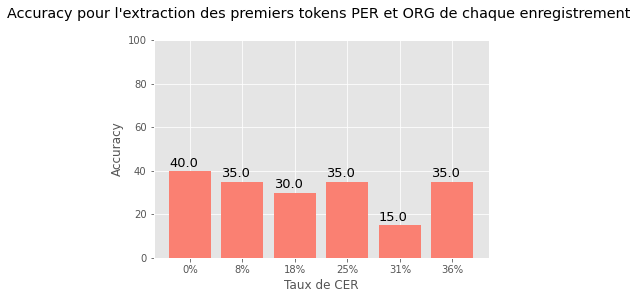

In [48]:
%matplotlib inline
plt.style.use('ggplot')
axes = plt.gca()
axes.set_ylim([0, 100])
x = ['0%', '8%', '18%', '25%', '31%', '36%']
y = [float(str(accuracy_cer_0)[0:5]), float(str(accuracy_cer_8)[0:5]), float(str(accuracy_cer_18)[0:5]), float(str(accuracy_cer_25)[0:5]), 
float(str(accuracy_cer_31)[0:5]), float(str(accuracy_cer_36)[0:5])]
x_pos = [i for i, _ in enumerate(x)]

for index,data in enumerate(y):
    plt.text(x=index-0.4, y=data+2, s=f"{data}" , fontdict=dict(fontsize=13))

plt.bar(x_pos, y, color='salmon')
plt.xlabel("Taux de CER")
plt.ylabel("Accuracy")
plt.title("Accuracy pour l'extraction des premiers tokens PER et ORG de chaque enregistrement \n")

plt.xticks(x_pos, x)

plt.show()

Avec ces résultats, on aurait donc du mal à indexer l'enregistrement à l'aide du nom de personne ou d'organisation qui lui est attribué.

De plus, on remarque que le taux de précision ne suit pas une courbe régulière. Au contraire, il semble assez aléatoire, sauf pour le taux de CER à 31% où la performance chute drastiquement. Le résultat du NER sur une transcription manuelle ne montre pas de différence significative, à 40% de précision, c'est 6 entités sur 10 qui ne sont pas correctement identifiées comme PER ou ORG.

## Expérience connexe - Nombre d'entités extraites selon taux de CER

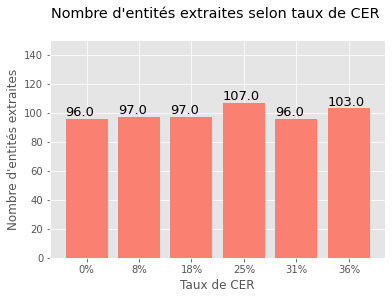

In [49]:
%matplotlib inline
plt.style.use('ggplot')
axes = plt.gca()
axes.set_ylim([0, 150])
x = ['0%', '8%', '18%', '25%', '31%', '36%']
y = [float(str(entity_count_cer_0)[0:5]), float(str(entity_count_cer_8)[0:5]), float(str(entity_count_cer_18)[0:5]), float(str(entity_count_cer_25)[0:5]), 
float(str(entity_count_cer_31)[0:5]), float(str(entity_count_cer_36)[0:5])]
x_pos = [i for i, _ in enumerate(x)]

for index,data in enumerate(y):
    plt.text(x=index-0.4, y=data+2, s=f"{data}" , fontdict=dict(fontsize=13))

plt.bar(x_pos, y, color='salmon')
plt.xlabel("Taux de CER")
plt.ylabel("Nombre d'entités extraites")
plt.title("Nombre d'entités extraites selon taux de CER \n")

plt.xticks(x_pos, x)

plt.show()

On observe que pour une même page, selon le taux de CER, le nombre d'entités extraites n'est pas régulier. Le taux de CER nous indique que selon la qualité de la transcription, les erreurs peuvent être différentes, et par conséquent troubler la pipeline de NLP, et donc le NER.